In [1]:
from tcrpeg.TCRpeg import TCRpeg
from tcrpeg.classification import classification
import pandas as pd
import numpy as np
import os
from tcrpeg.evaluate import evaluation
from tcrpeg.utils import plotting
from tcrpeg.word2vec import word2vec
import warnings
warnings.filterwarnings('ignore')

### Load TCRs; The 'TCRs_train.csv' is an example data that contains 100k TCRs randomly sampled from the universal TCR pool constructed using the 743 individual TCR repertoires from Emerson et al.

In [9]:
tcrs_train = pd.read_csv('tcrpeg/data/TCRs_train.csv',compression='gzip')['seq'].values
tcrs_train[:3]

array(['CASSLTFGNTIYF', 'CATGFPNYGYTF', 'CASSLGSGDYNEQFF'], dtype=object)

### Train a word2vec model to obtain the numerial embeddings for each amino acid. We also provide our pre-trained AA embeddings: 'tcrpeg/data/embedding_32.txt'.

In [3]:
aa_emb = word2vec(path=tcrs_train,epochs=1,batch_size=10,device='cuda:0',lr=0.0001,window_size=2,record_path='tcrpeg/data/your_aa_emb.txt')

100%|██████████| 603863/603863 [03:43<00:00, 2697.53it/s]

Loss at epo 1: 10.260348152463115


### Define and infer TCRpeg model

In [4]:
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='tcrpeg/data/embedding_32.txt',path_train=tcrs_train)
#create the TCRpeg model. 
model.create_model()
#begin inferring
model.train_tcrpeg(epochs=3,batch_size=64,lr=1e-3)

#model.save('path_to_save.pth') #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

  2%|▏         | 24/1562 [00:00<00:06, 233.39it/s]

Have loaded the data, total training seqs : 100000
begin the training process
begin epoch : 1


  2%|▏         | 25/1562 [00:00<00:06, 241.30it/s]

nll_loss: 22.110805093860503
begin epoch : 2


  2%|▏         | 25/1562 [00:00<00:06, 244.53it/s]

nll_loss: 19.777053723109365
The learning rate has beed reduced
begin epoch : 3


100%|██████████| 1562/1562 [00:06<00:00, 241.53it/s]

nll_loss: 19.578192820774913
The learning rate has beed reduced
Done training


### Load the plotting module and evaluation class

In [2]:
Plot = plotting()
eva = evaluation(model=model) # used for evaluate the probability inference

In [6]:
#load the test data, also randomly sampled from the test set of the universal TCR pool
test_data = pd.read_csv('tcrpeg/data/pdf_test.csv',compression='gzip')
data = {'seq':test_data['seq'].values,'count':test_data['count'].values} 
#evaluate the inference performance
r,p_data,p_infer = eva.eva_prob(path=data)
print('The Pearson\'s correlation coefficient is: ',r)

100%|██████████| 21/21 [00:00<00:00, 91.50it/s] 


Pearson correlation coefficient are : 0.8802
The Pearson's correlation coefficient is:  0.8801863409657704


### Make the inference plot

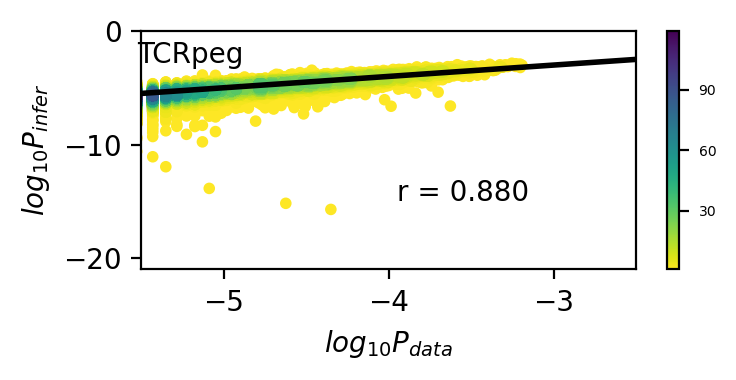

In [7]:
Plot.plot_prob(p_data,p_infer)

### Get the encodings of TCRs

In [8]:
seq_embs = model.get_embedding(tcrs_train[:100])
print(seq_embs.shape)
seq_embs[0,:][:10]

(100, 192)


array([ 0.8131257 , -0.08505   ,  0.814451  , -0.96779996, -0.80003494,
        0.08411529, -0.23147355,  0.4503739 ,  0.52408326, -0.8402053 ],
      dtype=float32)

### Generate TCR sequences

In [9]:
gens = model.generate_tcrpeg(num_to_gen=10000,batch_size=1000) #generate TCRs batch by batch
gens[:3]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


['CASSELVNGYTF', 'CASSLTDTKYEQYF', 'CASSMDRDRPQHF']

### Plot the distributions of length and each amino acids

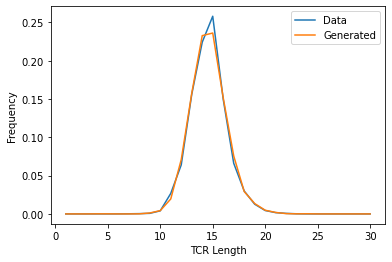

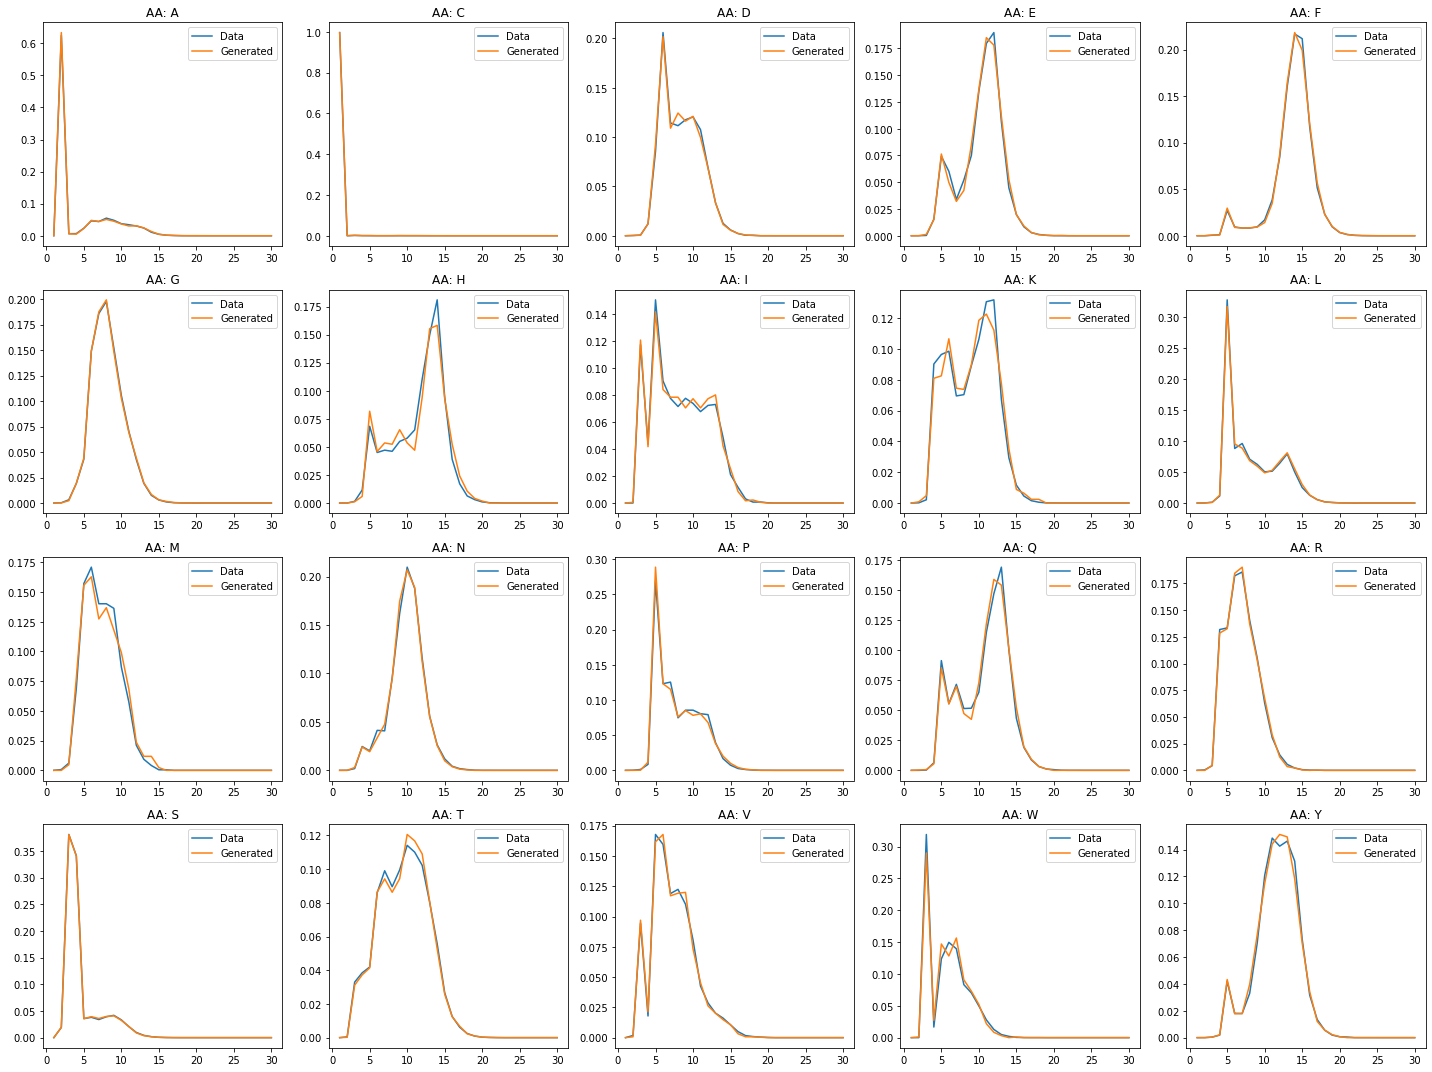

In [10]:
Plot.Length_Dis(tcrs_train,gens)
Plot.AAs_Dis(tcrs_train,gens)

### Generate TCR sequences along with corresponding V and J genes (TCRpeg_vj model)

In [3]:
#load tcrs along with v and j genes
tcrvj_train = pd.read_csv('tcrpeg/data/TCRs_train.csv',compression='gzip')
tcrvj_train[:3]

,seq,v,j
0,CASSLTFGNTIYF,TRBV5-8,TRBJ1-3
1,CATGFPNYGYTF,TRBV28,TRBJ1-2
2,CASSLGSGDYNEQFF,TRBV7-6,TRBJ2-1


In [4]:
# Define and infer TCRpeg_vj 
vj_data = [[tcrvj_train.iloc[i][0],tcrvj_train.iloc[i][1],tcrvj_train.iloc[i][2]] for i in range(len(tcrvj_train))] #vj_data should be in format [[seq1,v1,j1],[seq2,v2,j2]...]
model_vj  =TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='tcrpeg/data/embedding_32.txt',path_train=vj_data,vj=True)
model_vj.create_model(vj=True)
model_vj.train_tcrpeg_vj(epochs=1,batch_size=16,lr=1e-3)

Have loaded the data, total training seqs : 100000


  0%|          | 23/6250 [00:00<00:27, 223.24it/s]

begin the training process
begin epoch : 1


100%|██████████| 6250/6250 [00:26<00:00, 231.70it/s]

nll_loss: 20.631529029541017
v_loss: 3.2895059782409666
j_loss: 0.08174405239690095
Done training


In [5]:
#Generate seqs along with v and j genes
gens_vj = model_vj.generate_tcrpeg_vj(10000,1000)
[gens_vj[i][:3] for i in range(3)]

100%|██████████| 10/10 [00:00<00:00, 214.19it/s]


[['CASSGTQGLYGYTF', 'CASSLAEASNEQFF', 'CASSPSIDSLPSGNTIYF'],
 ['TRBV28', 'TRBV18', 'TRBV5-1'],
 ['TRBJ1-2', 'TRBJ2-1', 'TRBJ1-3']]

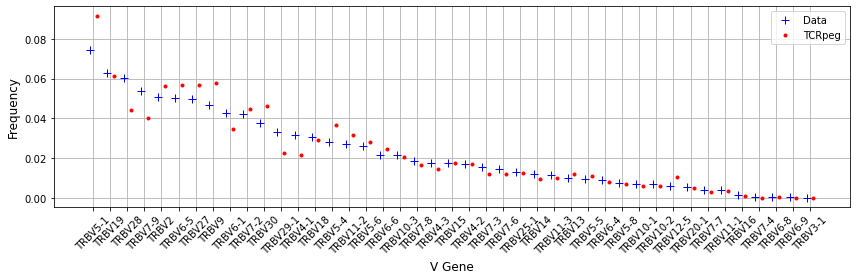

In [6]:
Plot.V_Dis(tcrvj_train['v'].values, gens_vj[1])

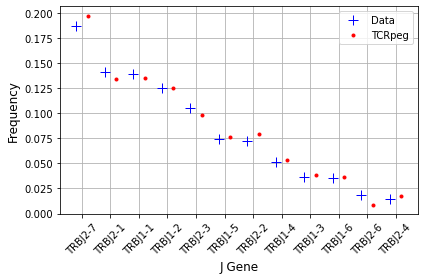

In [8]:
Plot.J_Dis(tcrvj_train['j'].values, gens_vj[2])

### Use TCRpeg-c for classification tasks

In [11]:
#load some data; This dataset is a subset of the caTCR dataset; total seqs: 8000;
data = pd.read_csv('tcrpeg/data/classification.csv')
x,y = list(data['seq']),list(data['label'])
#half of seqs are assigned as training/test data
x_train,y_train,x_test,y_test = x[:4000],y[:4000],x[4000:],y[4000:]

In [12]:
tcrpeg_c = classification(tcrpeg=model,embedding_size=64*3) #tcrpeg-c needs a pre-trained tcrpeg for providing emebddings
tcrpeg_c.train(x_train=x_train,y_train=y_train,epochs=3,batch_size=8,lr=1e-3,val_split=0.2)
auc,aup,y_pres,y_trues = tcrpeg_c.evaluate(x_test=x_test,y_test=y_test,batch_size=100)

  9%|▉         | 37/400 [00:00<00:00, 367.71it/s]

begin epoch : 1


  0%|          | 0/400 [00:00<?, ?it/s]

mean loss : 0.6817405745387077
evaluation, avg_loss and auc is :0.6768124437332154 and 0.595
begin epoch : 2


  0%|          | 0/400 [00:00<?, ?it/s]

mean loss : 0.6796675109863282
evaluation, avg_loss and auc is :0.669401830136776 and 0.614
The learning rate is reduced
begin epoch : 3


  0%|          | 0/40 [00:00<?, ?it/s]

mean loss : 0.6653231510519981
evaluation, avg_loss and auc is :0.6647045648097992 and 0.631
The learning rate is reduced
end training



100%|██████████| 40/40 [00:00<00:00, 529.12it/s]

evaluation, avg_loss and auc is :0.6535258129239082 and 0.65


In [13]:
##Save and load
#tcrpeg_c.save('path_to_save.pth') #save
#tcrpeg_c.load_model('path_to_save'.pth) #load

In [14]:
print('The AUC value is: ',auc)

The AUC value is:  0.65
